In [3]:
import os
import torch
import sys
sys.path.append('../../lib/exlib/src')

import sys
sys.path.append('../../src')
import sop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sop.utils.seed_all(42)

# config
exp_config = sop.ImageNetConfig()
val_config = exp_config.get_config('val_sm')
val_config['evaluation']['batch_size'] = 16
val_config

/opt/conda/envs/rapids/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/envs/rapids/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

{'dataset': {'name': 'imagenet_s',
  'root': '/shared_data0/weiqiuy/datasets/imagenet'},
 'training': {'batch_size': 16,
  'num_epochs': 20,
  'mask_batch_size': 64,
  'optimizer': {'name': 'adamw', 'lr': 5e-06, 'weight_decay': 0.01}},
 'evaluation': {'split': 'val', 'num_data': 1, 'batch_size': 16},
 'model': {'type': 'vit',
  'base': 'google/vit-base-patch16-224',
  'sop': '/shared_data0/weiqiuy/sop/exps/imagenet_lr5e-06_tgtnnz0.2_gg0.0600_gs0.0100_ft_identify_fixk_scratch_ks3/best',
  'num_classes': 1000}}

In [4]:
backbone_model, original_model, processor, backbone_config, model, config = sop.tasks.imagenet.get_model(val_config['model']['type'],
                                                                 backbone_model_name=val_config['model']['base'],
                                                                 backbone_processor_name=val_config['model']['base'],
                                                                 sop_model_name=val_config['model']['sop'], eval_mode=True
                                                                                                        )

backbone_model = backbone_model.to(device)
original_model = original_model.to(device)
model = model.to(device)

projection layer is not frozen
projection layer is not frozen
Loaded step 40100


In [4]:
methods = [
    'shap_20',
    'rise_20',
    'lime_20',
    'sop',
    'fullgrad',
    'gradcam',
    'intgrad',
    'attn',
    'archipelago',
    'mfaba',
    'agi',
    'ampe',
    'bcos',
    'xdnn',
    'bagnet',
]

In [6]:
from sop.metrics import get_acc

In [11]:
from sop.tasks.images.imagenet import get_explainer

debug = True
k = 0.2

# method = 'lime_20'
# explainer_name = method.split('_')[0]
method = 'shap_20'

if method == 'sop':
    explainer = model
else:
    explainer = get_explainer(original_model, backbone_model, method.split('_')[0], device)
    
method_list = method.split('_')
explainer_name = method_list[0]

if len(method_list) == 2:
    suffix = f'_{method_list[1]}'
else:
    suffix = ''

if method != 'sop':
    ATTR_VAL_DATA_DIR = f'/shared_data0/weiqiuy/sop/exps/imagenet_vit_1/attributions_seg/{explainer_name}_1_pred{suffix}/val'
else:
    ATTR_VAL_DATA_DIR = None
    
val_dataset, val_dataloader = sop.tasks.imagenet.get_dataset(val_config['dataset']['name'], 
                                          split=val_config['evaluation']['split'], 
                                          num_data=val_config['evaluation']['num_data'],
                                          batch_size=val_config['evaluation']['batch_size'],
                                                        attr_dir=ATTR_VAL_DATA_DIR,
                                          processor=processor, debug=debug)

  0%|          | 0/1001 [00:00<?, ?it/s]

Loaded 100 images and 100 classes


In [12]:
import numpy as np
from tqdm.auto import tqdm

results_all = {}
for k in tqdm(np.linspace(0.1, 1, 10)):
    results = get_acc(val_dataloader, explainer, method, device, k=k, eval_all=False)
    results_all[k] = results
    break

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [14]:
# save_dir = f'/shared_data0/weiqiuy/sop/results/sparsity/{val_config["dataset"]["name"]}/'
# os.makedirs(save_dir, exist_ok=True)

# results_path = f'{save_dir}/{method}.pt'

# torch.save(results, results_path)

# Load

In [1]:
methods = [
    'shap_20',
    'rise_20',
    'lime_20',
    'sop',
    'fullgrad',
    'gradcam',
    'intgrad',
    'attn',
    'archipelago',
    'mfaba',
    'agi',
    'ampe',
    'bcos',
    'xdnn',
    'bagnet',
]

In [7]:
results_all = {}
for method in methods:
    save_dir = f'/shared_data0/weiqiuy/sop/results/sparsity/{val_config["dataset"]["name"]}/'
    results_path = f'{save_dir}/{method}.pt'
    results = torch.load(results_path)
    results_all[method] = results

In [19]:
results_all[method].keys()

dict_keys([0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0])

In [25]:
results_all.keys()

dict_keys(['shap_20', 'rise_20', 'lime_20', 'sop', 'fullgrad', 'gradcam', 'intgrad', 'attn', 'archipelago', 'mfaba', 'agi', 'ampe', 'bcos', 'xdnn', 'bagnet'])

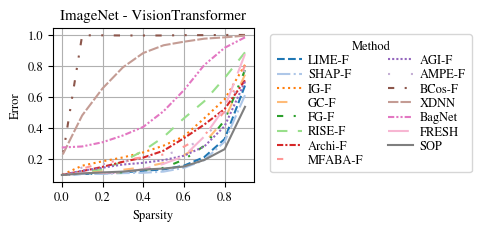

In [47]:
# Acc plot
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm

plt.rcParams.update({
    'font.size': 9,
    # 'font.family': [] #'Times New Roman'
})  # Set a default font size


name_mapping = {
    'lime_20': 'LIME-F',
    'shap_20': 'SHAP-F',
    'intgrad': 'IG-F',
    'gradcam': 'GC-F',
    'fullgrad': 'FG-F',
    'rise_20': 'RISE-F',
    'archipelago': 'Archi-F',
    'mfaba': 'MFABA-F',
    'agi': 'AGI-F',
    'ampe': 'AMPE-F',
    'bcos': 'BCos-F',
    'xdnn': 'XDNN',
    'bagnet': 'BagNet',
    'attn': 'FRESH',
    'sop': 'SOP',
}

# Data provided by the user
data = {key: results_all[key] for key in name_mapping}

# X-axis for the plot (assuming these are the points of interest or epochs)
# x = list(range(1, 11))
x = np.linspace(0.1, 1, 10)

colors_all = cm.get_cmap('tab20')  # The second argument specifies how many discrete colors to generate
# hatches_all = ['///', '\\\\\\', '---', '++++', 'xxxx', 'oo', 'OO', '...', '**', '\\\\\\...', '']
# hatches_all = ['///', '\\\\\\', '---', '++++', 'xxxx', 'oo','...', '**', '']

# # # Generate colors from the colormap
colors = [colors_all(i) for i in range(len(name_mapping))]  # tab10.N is 10
# hatches = [hatches_all[i] for i in range(len(name_mapping))]

# Assigning different line styles to each line for better differentiation
# line_styles = ['--', '-.', ':', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 10)), (0, (5, 5)), (0, (3, 10, 1, 10)), '-']
# line_styles = ['-'] * len(colors)
line_styles = [
    '--',                   # Dashed line
    '-.',                   # Dash-dot line
    ':',                    # Dotted line
    (0, (5, 10)),           # Long dashed line
    (0, (3, 5, 1, 5)),      # Dash-dot-dot line
    (0, (5, 5)),            # Densely dashed line
    (0, (3, 1, 1, 1)),      # Densely dash-dot line
    (0, (3, 10, 1, 10)),    # Loosely dash-dot line
    (0, (1, 1)),            # Densely dotted line
    (0, (1, 10)),           # Loosely dotted line
    (0, (3, 5, 1, 5, 1, 5)),  # Dash-dot-dot-dot line
    (0, (5, 1)),            # Densely dashed line (alternative)
    (0, (3, 1, 1, 1, 1, 1)),  # Densely dash-dot-dot line
    (0, (10, 5)),            # Loosely dashed line (alternative)
    '-',                    # Solid line
]

# Plotting with updated line styles
plt.figure(figsize=(2.6, 2))  # Adjusted for better visualization
for (key, values), style, color in zip(data.items(), line_styles, colors):
    # print(values)
    # print(list(range(len(values) - 1, -1, -1)))
    # print(list(values.values()))
    # print(key)
    plt.plot([1 - xi for xi in x], [1 - list(values.values())[i]['acc'] for i in range(len(values))], label=name_mapping[key], linestyle=style, color=color)

    # plt.plot(x, [1 - list(values.values())[i] for i in range(len(values) - 1, -1, -1)], label=name_mapping[key], linestyle=style, color=color)

plt.title('ImageNet - VisionTransformer')
plt.xlabel('Sparsity')
plt.ylabel('Error')
# plt.legend(loc='upper left', bbox_to_anchor=(0.5, -0.15), ncol=3)
legend = plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left',  ncol=2,
                   labelspacing=0.2, handlelength=2, handletextpad=0.5, 
                   handleheight=0.5, borderpad=0.5)
# plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2,
#            labelspacing=0.2, handlelength=1, handletextpad=0.5, 
#            handleheight=0.5, borderpad=0.5)
plt.grid(True)
plt.savefig('imagenet_figs/acc_sparsity_imagenet.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


In [16]:
save_dir, results_path

('/shared_data0/weiqiuy/sop/results/sparsity/imagenet_s/',
 '/shared_data0/weiqiuy/sop/results/sparsity/imagenet_s//shap_20.pt')

In [17]:
data = torch.load(results_path)

In [18]:
data

{'acc': 0.5625,
 'corrects': [False,
  False,
  False,
  True,
  False,
  True,
  False,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  False]}